# Tasks

- We will work with Google BigQuery from Colab
- Some part of the instructions is coming from https://colab.research.google.com/notebooks/bigquery.ipynb
- We will use covid-19-public-data
- In particular, we use extract the UK data
  1. Check what kind of data are available
  2. Find out what we can do with the data



## Authentication

The first step is to 

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Load pacakges

In [2]:
from google.cloud import bigquery
import pandas as pd

## Connect to big query

Go to the console and check your project name and paste here

In [3]:
project_id = "gv918-298014"

In [4]:
client = bigquery.Client(project=project_id)

## Run queries

We will use `bigquery-public-data.covid19_open_data.covid19_open_data`

### Simple query

Get five rows from the table

- How many rows in the table?
- How many columns exist?

In [12]:
df = client.query('''
SELECT * FROM `bigquery-public-data.covid19_open_data.covid19_open_data` LIMIT 10
''').to_dataframe()

In [16]:
client.query('''
SELECT COUNT(*) FROM `bigquery-public-data.covid19_open_data.covid19_open_data`
''').to_dataframe()

,f0_
0,7397720


In [14]:
df.shape

(10, 45)

### Explore the table

- How many countries in the data
- How many UK rows?
- What's the geographical units for the UK subnational levels

In [18]:
client.query('''
SELECT COUNT(DISTINCT country_name) FROM `bigquery-public-data.covid19_open_data.covid19_open_data`
''').to_dataframe()

,f0_
0,248


In [21]:
client.query('''
SELECT COUNT(country_name) 
FROM `bigquery-public-data.covid19_open_data.covid19_open_data` 
WHERE country_code = "GB"
''').to_dataframe()

,f0_
0,67768


- What's the latest date in the UK?

In [25]:
client.query('''
SELECT MAX(date) 
FROM `bigquery-public-data.covid19_open_data.covid19_open_data` 
WHERE country_code = "GB"
''').to_dataframe()

,f0_
0,2020-12-09


- On 1 December 2020, at subregion2 level
  - Which sub region had the highest number of qumulative cases

In [31]:
client.query('''
SELECT *
FROM `bigquery-public-data.covid19_open_data.covid19_open_data` 
WHERE country_code = "GB" AND date = "2020-12-01" AND subregion2_code != "None"
ORDER BY cumulative_confirmed	DESC
''').to_dataframe()

,date,location_key,country_code,country_name,subregion1_code,subregion1_name,subregion2_code,subregion2_name,iso_3166_1_alpha_2,iso_3166_1_alpha_3,aggregation_level,new_confirmed,new_deceased,new_recovered,new_tested,cumulative_confirmed,cumulative_deceased,cumulative_recovered,cumulative_tested,new_hospitalized_patients,new_intensive_care_patients,new_ventilator_patients,cumulative_hospitalized_patients,cumulative_intensive_care_patients,cumulative_ventilator_patients,current_hospitalized_patients,current_intensive_care_patients,current_ventilator_patients,mobility_transit_stations,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_residential,mobility_workplaces,wikidata_id,datacommons_id,openstreetmap_id,latitude,longitude,location_geometry,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm
0,2020-12-01,GB_ENG_E10000017,GB,United Kingdom,ENG,England,E10000017,Lancashire,GB,GBR,2,318.0,None,None,None,48486.0,None,None,None,None,None,None,None,None,None,None,None,None,-38.0,-36.0,-5.0,35.0,13.0,-30.0,Q21279371,None,88081.0,53.800000,-2.600000,POINT(-2.6 53.8),4.783333,2.094444,6.877778,0.812800,None
1,2020-12-01,GB_ENG_E08000025,GB,United Kingdom,ENG,England,E08000025,Birmingham,GB,GBR,2,325.0,None,None,None,41136.0,None,None,None,None,None,None,None,None,None,None,None,None,-56.0,-47.0,-8.0,-12.0,14.0,-35.0,Q20986424,None,162378.0,52.480480,-1.898230,POINT(-1.89823 52.48048),4.316667,1.255556,7.177778,0.254000,None
2,2020-12-01,GB_ENG_E08000035,GB,United Kingdom,ENG,England,E08000035,Leeds,GB,GBR,2,200.0,None,None,None,36229.0,None,None,None,None,None,None,None,None,None,None,None,None,-61.0,-51.0,-11.0,33.0,17.0,-45.0,Q774015,nuts/UKE42,118362.0,53.799167,-1.549167,POINT(-1.549167 53.799167),4.077778,0.705556,6.711111,0.203200,None
3,2020-12-01,GB_SCT_S08000031,GB,United Kingdom,SCT,Scotland,S08000031,Greater Glasgow and Clyde,GB,GBR,2,275.0,None,None,None,33302.0,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None
4,2020-12-01,GB_ENG_E10000016,GB,United Kingdom,ENG,England,E10000016,Kent,GB,GBR,2,769.0,None,None,None,32234.0,None,None,None,None,None,None,None,None,None,None,None,None,-35.0,-40.0,-7.0,3.0,15.0,-33.0,Q21694674,None,172385.0,51.190000,0.730000,POINT(0.73 51.19),5.522222,3.522222,7.983333,0.203200,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,2020-12-01,GB_ENG_E06000017,GB,United Kingdom,ENG,England,E06000017,Rutland,GB,GBR,2,5.0,None,None,None,490.0,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,-29.0,Q23107,nuts/UKF22,2703126.0,52.650000,-0.633333,POINT(-0.633333 52.65),4.166667,2.228395,6.987654,1.241778,None
178,2020-12-01,GB_SCT_S08000028,GB,United Kingdom,SCT,Scotland,S08000028,Western Isles,GB,GBR,2,1.0,None,None,None,82.0,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None
179,2020-12-01,GB_SCT_S08000026,GB,United Kingdom,SCT,Scotland,S08000026,Shetland,GB,GBR,2,1.0,None,None,None,76.0,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,-19.0,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None
180,2020-12-01,GB_SCT_S08000025,GB,United Kingdom,SCT,Scotland,S08000025,Orkney,GB,GBR,2,0.0,None,None,None,38.0,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,-18.0,None,None,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None


- Mobility check on 1 Dec
  - How is the modiblity data look like?
    - `mobility_retail_and_recreation`
    - `mobility_parks`
    - `mobility_workplaces`

In [32]:
client.query('''
SELECT *
FROM `bigquery-public-data.covid19_open_data.covid19_open_data` 
WHERE country_code = "GB" AND date = "2020-12-01" AND subregion2_code != "None"
ORDER BY cumulative_confirmed	DESC
''').to_dataframe().describe()

,aggregation_level,new_confirmed,cumulative_confirmed,mobility_transit_stations,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_residential,mobility_workplaces,openstreetmap_id,latitude,longitude,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm
count,182.0,181.000000,181.000000,124.000000,126.000000,126.000000,105.000000,125.000000,129.000000,1.450000e+02,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,2.0,87.762431,9130.441989,-41.983871,-39.023810,-5.277778,11.447619,13.288000,-33.038760,4.554163e+05,52.616600,-1.594282,4.784354,2.199794,7.348447,0.603932
std,0.0,89.892429,7766.718995,11.530084,10.197619,8.071321,21.025617,2.555248,7.165895,1.509017e+06,1.275488,1.718141,1.000633,1.187482,0.918018,0.533091
min,2.0,0.000000,38.000000,-79.000000,-89.000000,-72.000000,-84.000000,7.000000,-66.000000,1.018700e+04,50.383330,-7.494000,2.411111,-0.761111,4.950000,0.025400
25%,2.0,37.000000,4148.000000,-50.250000,-43.000000,-8.000000,2.000000,12.000000,-37.000000,8.027700e+04,51.500000,-2.274028,4.200000,1.505556,6.865123,0.093134
50%,2.0,62.000000,6811.000000,-41.500000,-39.000000,-5.000000,12.000000,13.000000,-32.000000,1.466560e+05,52.480480,-1.333333,4.772222,2.160494,7.350000,0.533400
75%,2.0,103.000000,11211.000000,-32.750000,-35.000000,-1.000000,21.000000,15.000000,-28.000000,1.624880e+05,53.563750,-0.273889,5.105556,3.122222,7.716667,0.914400
max,2.0,769.000000,48486.000000,-18.000000,-5.000000,10.000000,60.000000,21.000000,-18.000000,9.448449e+06,55.203000,1.000000,7.788889,5.833333,10.044444,2.257778


## Work with the Essex data

We can get the essex county data. Using it:

- Plot the case figure growth by date
- Plot mobility changes by date

Anything interesting?


In [33]:
!pip install geopandas

In [91]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import wkt

sns.set_style('whitegrid')

In [78]:
essex_df = client.query('''
SELECT * FROM `bigquery-public-data.covid19_open_data.covid19_open_data` WHERE country_name = "United Kingdom" AND location_geometry IS NOT NULL
''').to_dataframe()

In [79]:
essex_df['location_geometry'] = essex_df['location_geometry'].astype(str)


In [80]:
essex_df['location_geometry'] = essex_df['location_geometry'].apply(wkt.loads)


In [81]:
gdf = gpd.GeoDataFrame(essex_df, geometry='location_geometry')

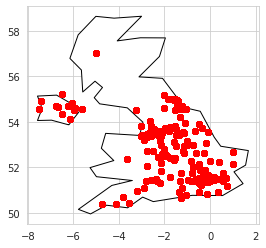

In [96]:
essex = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = essex[essex.name == 'United Kingdom'].plot(color='white', edgecolor='black')

gdf.plot(ax=ax, color='red')
plt.show()

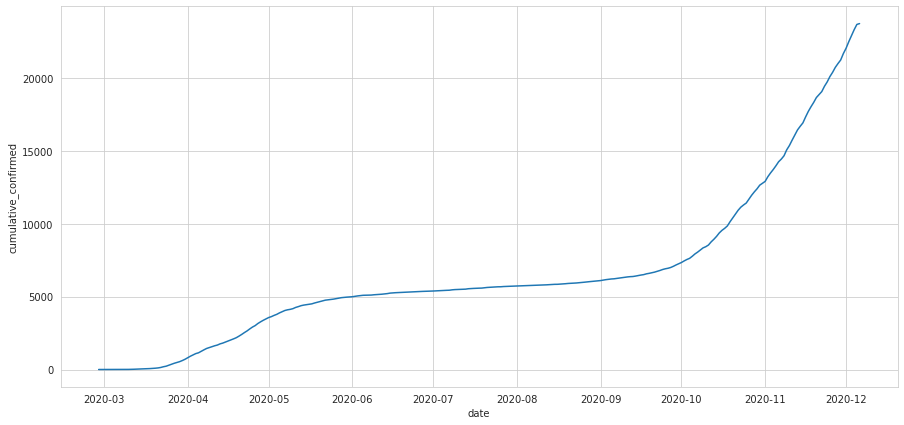

In [39]:
fig, ax = plt.subplots(1, figsize=(15,7))
sns.lineplot(x='date', y='cumulative_confirmed', data = essex_df)

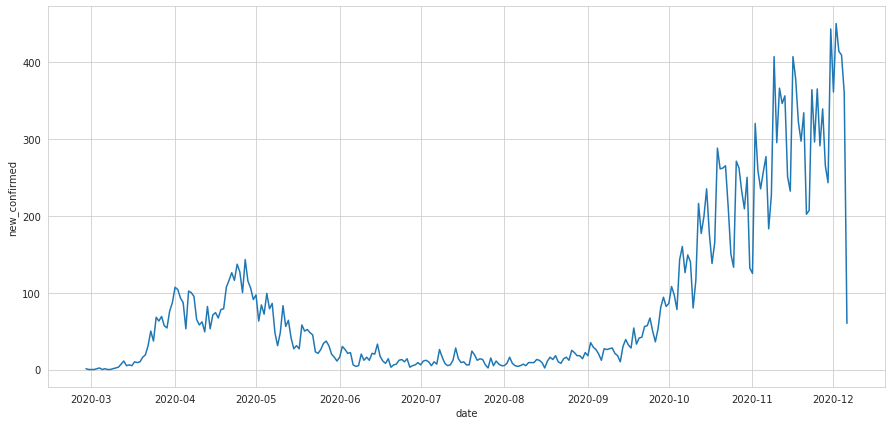

In [40]:
fig, ax = plt.subplots(1, figsize=(15,7))
sns.lineplot(x='date', y='new_confirmed', data = essex_df)